In [20]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib.patches import Ellipse
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from hmmlearn.hmm import GaussianHMM

print(os.getcwd())
# os.chdir('../')
print(os.getcwd())

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1


In [2]:
df = pd.read_csv('wbl_05_22_super_sabbatical_processed.csv')


Summary descriptive statistics

In [3]:
# Calculate the total number of participants
total_participants = df['playerId'].nunique()

# Calculate the total number of dyads (assuming dyads are represented by 'groupid')
total_dyads = df['groupId'].nunique()

# Calculate the gender breakdown
gender_counts = df['demographics_gender'].value_counts(normalize=True) * 100  # Percentage breakdown
male_percentage = gender_counts.get('male', 0.0)
female_percentage = gender_counts.get('female', 0.0)
unknown_percentage = gender_counts.get('', 0.0)

df['age'] = 2024 - df['demographics_birth_year']

# Calculate age statistics (mean and standard deviation)
mean_age = df['age'].mean()
std_age = df['age'].std()

print(f"Total participants: {total_participants}")
print(f"Total dyads: {total_dyads}")
print(f"Gender breakdown: {male_percentage:.1f}% male, {female_percentage:.1f}% female, {unknown_percentage:.1f}% unknown")
print(f"Mean age: {mean_age:.1f} years, SD: {std_age:.1f} years")

Total participants: 94
Total dyads: 47
Gender breakdown: 32.6% male, 67.4% female, 0.0% unknown
Mean age: 22.9 years, SD: 6.5 years


In [4]:
# For Agreement reached

subset = df[['groupId', 'deal_sheet_agreement_binary']]

group_counts = subset.groupby('groupId')['deal_sheet_agreement_binary'].value_counts().unstack(fill_value=0)

two_yes = group_counts[(group_counts['Yes'] == 2) & (group_counts['No'] == 0)].shape[0]
one_yes_one_no = group_counts[(group_counts['Yes'] == 1) & (group_counts['No'] == 1)].shape[0]
two_nos = group_counts[(group_counts['Yes'] == 0) & (group_counts['No'] == 2)].shape[0]

print(f"Number of groupIds with 2 YES: {two_yes}")
print(f"Number of groupIds with 1 YES and 1 NO: {one_yes_one_no}")
print(f"Number of groupIds with 2 NOs: {two_nos}")

Number of groupIds with 2 YES: 43
Number of groupIds with 1 YES and 1 NO: 1
Number of groupIds with 2 NOs: 2


In [5]:
# For Trip reached

subset = df[['groupId', 'deal_sheet_trip_binary']]


group_counts = subset.groupby('groupId')['deal_sheet_trip_binary'].value_counts().unstack(fill_value=0)


two_yes = group_counts[(group_counts['Yes'] == 2) & (group_counts['No'] == 0)].shape[0]
one_yes_one_no = group_counts[(group_counts['Yes'] == 1) & (group_counts['No'] == 1)].shape[0]
two_nos = group_counts[(group_counts['Yes'] == 0) & (group_counts['No'] == 2)].shape[0]


print(f"Number of groupIds with 2 YES: {two_yes}")
print(f"Number of groupIds with 1 YES and 1 NO: {one_yes_one_no}")
print(f"Number of groupIds with 2 NOs: {two_nos}")

Number of groupIds with 2 YES: 39
Number of groupIds with 1 YES and 1 NO: 5
Number of groupIds with 2 NOs: 2


In [6]:
# For Return Fund reached

subset = df[['groupId', 'deal_sheet_return_fund_binary']]


group_counts = subset.groupby('groupId')['deal_sheet_return_fund_binary'].value_counts().unstack(fill_value=0)


two_yes = group_counts[(group_counts['Yes'] == 2) & (group_counts['No'] == 0)].shape[0]
one_yes_one_no = group_counts[(group_counts['Yes'] == 1) & (group_counts['No'] == 1)].shape[0]
two_nos = group_counts[(group_counts['Yes'] == 0) & (group_counts['No'] == 2)].shape[0]


print(f"Number of groupIds with 2 YES: {two_yes}")
print(f"Number of groupIds with 1 YES and 1 NO: {one_yes_one_no}")
print(f"Number of groupIds with 2 NOs: {two_nos}")

Number of groupIds with 2 YES: 25
Number of groupIds with 1 YES and 1 NO: 14
Number of groupIds with 2 NOs: 7


Clustering on Task and Relationship

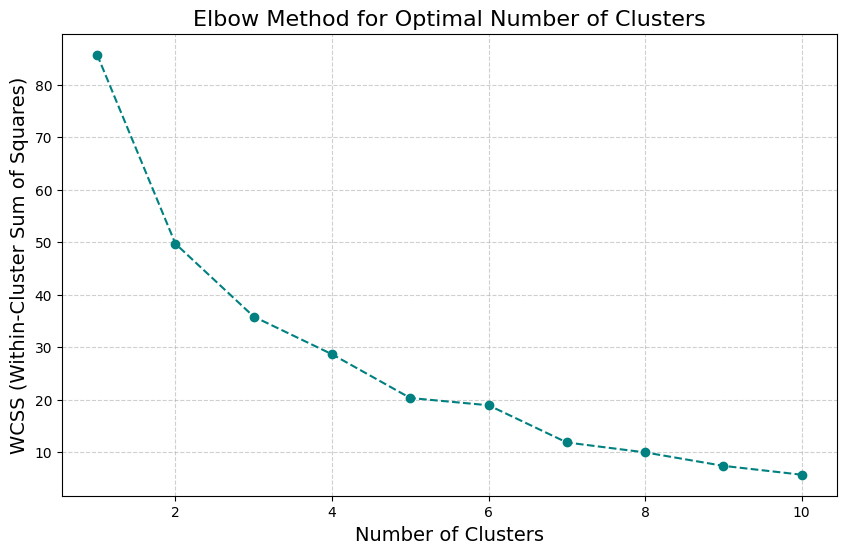

In [7]:
# Calculate Task Conflict and Relationship Conflict for each group
df['Task_Conflict'] = df[['post_negotiation_conflict_1', 'post_negotiation_conflict_2']].mean(axis=1)
df['Relationship_Conflict'] = df[['post_negotiation_conflict_3', 'post_negotiation_conflict_4']].mean(axis=1)

# Group by groupID and calculate the average Task and Relationship Conflict for each group
group_conflicts = df.groupby('groupId')[['Task_Conflict', 'Relationship_Conflict']].mean().reset_index()

# Determine the optimal number of clusters using the Elbow Method
wcss = []
max_clusters = 10  # Maximum number of clusters to test

for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(group_conflicts[['Task_Conflict', 'Relationship_Conflict']])
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--', color='teal')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=14)
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

                       groupId  Task_Conflict  Relationship_Conflict  Cluster  \
0   01HYGGKFHG8BZ3KW7ZDR0KGC4N           6.75                   3.50        1   
1   01HYGGM69HQN5GHTMDC1D1M24W           5.00                   3.00        1   
2   01HYGGMT9R24HQ95866Y6BBDES           5.25                   2.25        1   
3   01HYGGNS7A8Y691JXB24RMZ83G           6.50                   3.50        1   
4   01HYGGNVDW9MXKDB9T4WG2GW8M           3.00                   1.00        0   
5   01HYGGPM8PPG1XP0ZX8JQH9BHH           5.25                   2.25        1   
6   01HYGGPVVFQ5KKAYPXSWBQ5GX2           3.75                   2.50        0   
7   01HYGGQ7PWKMP8E7DR30SQ7YQ0           5.75                   4.00        1   
8   01HYGGQDQ90NV6F5XQ253XWHK3           6.00                   2.25        1   
9   01HYGGQDQCG0Q9FK0NAQDNHQXK           4.00                   4.00        1   
10  01HYGGQH1YTD0YH3Q79X4HKEQH           6.00                   3.25        1   
11  01HYGGR7XVC5XVR3XY0DSB0E

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


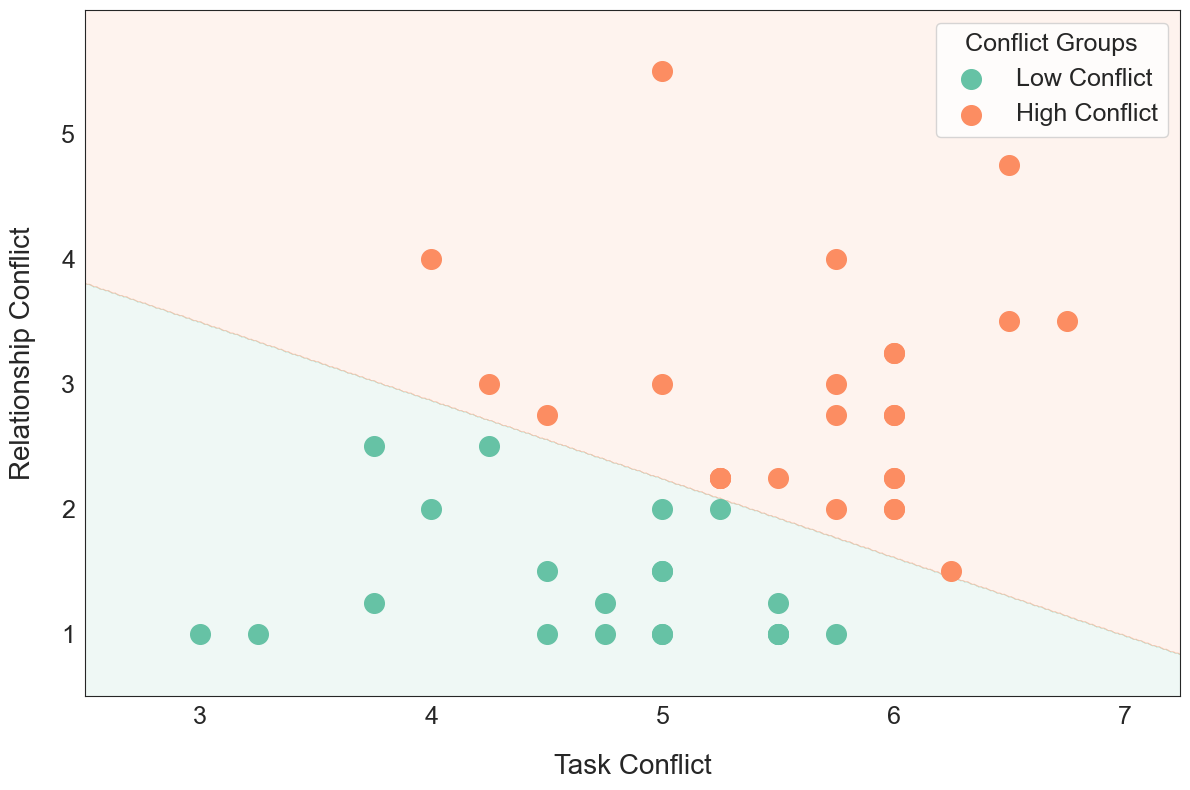

In [37]:
optimal_clusters = 2  # Update this based on the elbow point observed

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
group_conflicts['Cluster'] = kmeans.fit_predict(group_conflicts[['Task_Conflict', 'Relationship_Conflict']])


# Relabel the clusters
group_conflicts['Cluster_Label'] = group_conflicts['Cluster'].replace({0: 'Low Conflict', 1: 'High Conflict', 2: 'Moderate Conflict'})

print(group_conflicts)
# Save the groups, cluster IDs, and average conflict scores to a CSV file
# output_file_path = './Output/super_May22/group_clusters.csv'
# group_conflicts.to_csv(output_file_path, index=False)

# Generate a mesh grid for shading the cluster areas
x_min, x_max = group_conflicts['Task_Conflict'].min() - 0.5, group_conflicts['Task_Conflict'].max() + 0.5
y_min, y_max = group_conflicts['Relationship_Conflict'].min() - 0.5, group_conflicts['Relationship_Conflict'].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict the cluster for each point in the mesh grid
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the clustering results
plt.figure(figsize=(12, 8))
sns.set_style("white")  # Minimalist grid
palette = sns.color_palette("Set2", optimal_clusters)

# Plot the shaded cluster boundaries
plt.contourf(xx, yy, Z, alpha=0.1, cmap=ListedColormap(palette))

# Scatter plot for each cluster
for cluster in range(optimal_clusters):
    cluster_data = group_conflicts[group_conflicts['Cluster'] == cluster]
    plt.scatter(
        cluster_data['Task_Conflict'], 
        cluster_data['Relationship_Conflict'], 
        s=200,  # Larger points
        label=f"{cluster_data['Cluster_Label'].iloc[0]}", 
        color=palette[cluster], 
        # edgecolor='black', 
        # linewidth=0.5 
        alpha=1  # Slight transparency for elegance
    )
    

# Add cluster labels directly to areas
# cluster_centers = kmeans.cluster_centers_
# for i, (center_x, center_y) in enumerate(cluster_centers):
#     plt.text(
#         center_x, 
#         center_y, 
#         f"{group_conflicts['Cluster_Label'].unique()[i]}", 
#         fontsize=15, 
#         weight='bold', 
#         color='black', 
#         ha='center', 
#         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3')
#     )

# Add centroids
# centroids = kmeans.cluster_centers_
# plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='black', marker='X', edgecolor='white', linewidth=2)

# Axis labels and title
plt.xlabel('Task Conflict', fontsize=20, labelpad=18)
plt.ylabel('Relationship Conflict', fontsize=20, labelpad=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Legend (optional if cluster labels are inside areas)
plt.legend(fontsize=18, loc='upper right', frameon=True, title='Conflict Groups', title_fontsize=18)

# Save and show the plot
plt.tight_layout()
plt.savefig('./Output/super_May22/clean_cluster_plot.png', dpi=300)
plt.show()

In [12]:
# Group by groupID and calculate the average Task and Relationship Conflict for each group
# group_conflicts = df.groupby('groupId')[['Task_Conflict', 'Relationship_Conflict', 'Cluster_Label']].mean().reset_index()

# Calculate the Pearson correlation
correlation, p_value = stats.pearsonr(group_conflicts['Task_Conflict'], group_conflicts['Relationship_Conflict'])

# Degrees of Freedom (n - 2, where n is the number of data points)
n = len(group_conflicts)  # Number of groups
degrees_of_freedom = n - 2

# Display the results
print(f"Pearson Correlation Coefficient: {correlation:.2f}")
print(f"P-Value: {p_value:.4f}")
print(f"Degrees of Freedom: {degrees_of_freedom}")

Pearson Correlation Coefficient: 0.31
P-Value: 0.0328
Degrees of Freedom: 45


Segmenting conversations by conflict cluster

In [30]:
df_text = pd.read_csv('./Output/super_May22/Text_agg.csv')

In [31]:
# Extract the last 6 characters from PairID and groupId
df_text['MergeKey'] = df_text['PairID'].str[-6:]
group_conflicts['MergeKey'] = group_conflicts['groupId'].str[-6:]

# Perform a left join
merged_data = df_text.merge(group_conflicts, on='MergeKey', how='left')

# Drop the temporary MergeKey column if not needed
# merged_data.drop(columns=['MergeKey'], inplace=True)

In [32]:
list(merged_data)

['Pair_Speaker_turn',
 'PairID',
 'PersonID',
 'Speaker',
 'Speaker_original',
 'Turn',
 'Word',
 'Start Time',
 'End Time',
 'Backchannel',
 'Overlap',
 'Contested',
 'Duration',
 'Sentiment',
 'word_count',
 'MergeKey',
 'groupId',
 'Task_Conflict',
 'Relationship_Conflict',
 'Cluster',
 'Cluster_Label']

In [40]:
# get the datasets
# data = merged_data.copy()
# group_conflicts.rename(columns={'groupId':'PairID'}, inplace=True)

# Normalize the features
scaler = MinMaxScaler()
merged_data[['word_count_scaled', 'Sentiment_scaled', 'Contested_scaled']] = scaler.fit_transform(
    merged_data[['word_count', 'Sentiment', 'Contested']]
)

print(list(merged_data))
# Merge group_conflicts with data
# merged_data = data.merge(group_conflicts, on='PairID', how='left')

# Function to create a Left-to-Right transition matrix
def left_to_right_transition_matrix(n_states):
    """Create a Left-to-Right transition matrix for HMM."""
    transition_matrix = np.zeros((n_states, n_states))
    for i in range(n_states):
        if i < n_states - 1:
            transition_matrix[i, i] = 0.7  # Self-transition probability
            transition_matrix[i, i + 1] = 0.3  # Forward transition probability
        else:
            transition_matrix[i, i] = 1.0  # Last state stays in itself
    return transition_matrix

# Function to enforce varying number of stages using BIC
def find_optimal_hmm(features, min_states=2, max_states=5):
    best_bic = float('inf')
    best_model = None
    best_num_states = None
    for n_states in range(min_states, max_states + 1):
        try:
            # Initialize HMM with Left-to-Right constraints
            hmm_model = GaussianHMM(n_components=n_states, covariance_type="diag", random_state=42)
            hmm_model.startprob_ = np.zeros(n_states)
            hmm_model.startprob_[0] = 1.0  # Start always from the first state
            hmm_model.transmat_ = left_to_right_transition_matrix(n_states)
            hmm_model.fit(features)
            
            # Compute BIC
            n_params = (
                n_states ** 2 +  # Transition probabilities
                n_states * features.shape[1] * 2 +  # Means and variances
                n_states  # Initial probabilities
            )
            log_likelihood = hmm_model.score(features)
            bic = -2 * log_likelihood + n_params * np.log(features.shape[0])
            
            if bic < best_bic:
                best_bic = bic
                best_model = hmm_model
                best_num_states = n_states
        except Exception:
            # Ignore convergence errors
            continue
    return best_model, best_num_states

# Enforce sequential order for StageCluster
def enforce_sequential_order(df, cluster_col='StageCluster'):
    """
    Enforce sequential order for StageCluster within each conversation (PairID).
    Adjusts StageCluster so it only progresses forward or stays the same.
    """
    corrected_clusters = []
    
    for pair_id, group in df.groupby('PairID'):
        current_max = -1  # Track the maximum StageCluster seen so far
        corrected = []

        for cluster in group[cluster_col]:
            if cluster >= current_max:
                current_max = cluster  # Allow progression or staying the same
            corrected.append(current_max)  # Enforce monotonic progression
        
        corrected_clusters.extend(corrected)
    
    df[cluster_col] = corrected_clusters
    return df

# Segment each conversation
stages = []
for pair_id, group in merged_data.groupby('PairID'):
    # Extract features
    features = group[['word_count_scaled', 'Sentiment_scaled', 'Contested_scaled']].values

    # Find the optimal HMM for this conversation
    hmm_model, n_states = find_optimal_hmm(features)

    if hmm_model:
        # Predict stages with the best HMM
        group['StageCluster'] = hmm_model.predict(features)

        # Map clusters to generic stage names
        group['Stage'] = group['StageCluster'].map(lambda x: f"Stage {x + 1}")
    else:
        group['StageCluster'] = -1
        group['Stage'] = "Unclassified"

    stages.append(group)

# Combine processed conversations
data_segmented = pd.concat(stages, ignore_index=True)

# Enforce sequential order on StageCluster
data_segmented = enforce_sequential_order(data_segmented, cluster_col='StageCluster')

# Update Stage labels based on corrected clusters
data_segmented['Stage'] = data_segmented['StageCluster'].map(lambda x: f"Stage {x + 1}")

print(list(data_segmented))
# Summarize conversation stages for each conflict group
summary = (
    data_segmented.groupby(['Cluster_Label', 'StageCluster'])
    .agg(
        avg_turns=('Turn', lambda x: len(x.unique())),  # Average count of unique turns
        std_turns=('Turn', lambda x: np.std([len(list(g)) for _, g in x.groupby(x)])),
        # avg_wordcount=('word_count', lambda x: x.sum() / len(x)),  # Average wordcount by turn
        # std_wordcount=('word_count', lambda x: np.sqrt(np.mean((x - x.sum() / len(x))**2))),
        sum_wordcount=('word_count', 'sum'),
        # std_wordcount=('word_count', 'std'),
        avg_sentiment=('Sentiment', 'mean'),
        std_sentiment=('Sentiment', 'std'),
        avg_contested=('Contested', 'mean'),
        std_contested=('Contested', 'std'),
        typical_start_time=('Start Time', 'mean'),
        typical_end_time=('End Time', 'mean')
    )
    .reset_index()
)

summary['avg_wordcount'] = summary['sum_wordcount'] / summary['avg_turns']
# summary['std_wordcount'] = np.sqrt(summary['sum_wordcount'] / summary['avg_turns'])
summary['avg_duration'] = summary['typical_end_time'] - summary['typical_start_time']

# Save the summary
data_segmented.to_csv("./Output/super_May22/Segmented_Conversations_With_Conflicts.csv", index=False)
summary.to_csv("./Output/super_May22/Conflict_Group_Stage_Summary.csv", index=False)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Model is not converging.  Current: 372.4900306935946 is not greater than 372.55778485148363. Delta is -0.06775415788905548
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' cont

['Pair_Speaker_turn', 'PairID', 'PersonID', 'Speaker', 'Speaker_original', 'Turn', 'Word', 'Start Time', 'End Time', 'Backchannel', 'Overlap', 'Contested', 'Duration', 'Sentiment', 'word_count', 'MergeKey', 'groupId', 'Task_Conflict', 'Relationship_Conflict', 'Cluster', 'Cluster_Label', 'word_count_scaled', 'Sentiment_scaled', 'Contested_scaled']


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' c

['Pair_Speaker_turn', 'PairID', 'PersonID', 'Speaker', 'Speaker_original', 'Turn', 'Word', 'Start Time', 'End Time', 'Backchannel', 'Overlap', 'Contested', 'Duration', 'Sentiment', 'word_count', 'MergeKey', 'groupId', 'Task_Conflict', 'Relationship_Conflict', 'Cluster', 'Cluster_Label', 'word_count_scaled', 'Sentiment_scaled', 'Contested_scaled', 'StageCluster', 'Stage']
